In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
# pd.set_option('display.max_columns', 1000)
# pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('..')

In [2]:
DATA = Path('data')
RAW  = DATA/'raw'
SUBMISSIONS = DATA/'submissions'

In [3]:
train      = pd.read_csv(RAW/'train_jqd04QH.csv', low_memory=False)
test       = pd.read_csv(RAW/'test_GYi4Gz5.csv', low_memory=False)
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)

In [4]:
id_col = 'enrollee_id'
cat_cols = ['city', 'gender', 'relevent_experience', 'enrolled_university', 
            'education_level', 'major_discipline', 'experience', 'company_size', 
            'company_type', 'last_new_job']
num_cols = ['city_development_index', 'training_hours']
target_col = 'target'

In [14]:
train.isnull().sum(axis=0)

enrollee_id                  0
city                         0
city_development_index       0
gender                    4098
relevent_experience          0
enrolled_university        342
education_level            457
major_discipline          2838
experience                  59
company_size              4779
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

In [27]:
test.isnull().sum(axis=0)

enrollee_id                  0
city                         0
city_development_index       0
gender                    3388
relevent_experience          0
enrolled_university        279
education_level            395
major_discipline          2393
experience                  44
company_size              4051
company_type              4330
last_new_job               304
training_hours               0
dtype: int64

In [9]:
for col in cat_cols:
    print(col, train[col].nunique(), sep='\t\t')

city		123
gender		3
relevent_experience		2
enrolled_university		3
education_level		5
major_discipline		6
experience		22
company_size		8
company_type		6
last_new_job		6


In [24]:
train['last_new_job'].value_counts()

1        7567
>4       3339
2        2835
never    2186
4        1038
3        1027
Name: last_new_job, dtype: int64

In [17]:
def get_dict(labels):
    return {label: idx for idx, label in enumerate(labels)}

In [25]:
labels = {
    'enrolled_university': get_dict(['no_enrollment', 'Part time course',
                                     'Full time course']),
    'education_level': get_dict(['Primary School', 'High School', 
                                 'Graduate', 'Masters', 'Phd']),
    'experience': get_dict(['<1'] + [str(x) for x in range(1,21)] + ['>20']),
    'company_size': get_dict(['<10', '10/49', '50-99', '100-500', '500-999', 
                              '1000-4999', '5000-9999', '10000+']),
    'last_new_job': get_dict([str(x) for x in range(1,5)] + ['>4', 'never'])
}

## Fill na

In [41]:
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

In [32]:
for col in labels:
    train[col] = train[col].map(labels[col])
    test[col] = test[col].map(labels[col])

In [34]:
from src.utils import to_cat_codes, apply_cats
to_cat_codes(train, [c for c in cat_cols if c not in labels])
apply_cats(test, train)
for col in cat_cols: 
    if col not in labels:
        train[col] = train[col].cat.codes
        test[col] = test[col].cat.codes

In [43]:
for col in labels:
    train[f'{col}_num'] = train[col]
    test[f'{col}_num'] = test[col]

## Catboost

In [45]:
columns = list(train.drop([id_col, target_col], axis=1))
cat_indices = [i for i, col in enumerate(columns) if col in cat_cols]

In [55]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [52]:
kfolds = StratifiedKFold(n_splits=5, random_state=42)

In [56]:
def run_model(model, X_trn, y_trn, X_tst, kfolds):
    y_tests = []
    for trn_idx, val_idx in kfolds.split(X_trn, y_trn):
        model.fit(X_trn.iloc[trn_idx], y_trn.iloc[trn_idx], 
                  eval_set=[(X_trn.iloc[val_idx], y_trn.iloc[val_idx])],
                  use_best_model=True,
                  cat_features=cat_indices)
        y_trn_pred = model.predict_proba(X_trn.iloc[trn_idx])[:,1]
        y_val_pred = model.predict_proba(X_trn.iloc[val_idx])[:,1]
        print(f'Train AUC: {roc_auc_score(y_trn.iloc[trn_idx], y_trn_pred):.4f}')
        print(f'Val AUC: {roc_auc_score(y_trn.iloc[val_idx], y_val_pred):.4f}')        
        y_tests.append(model.predict_proba(X_tst)[:,1])
        print()
        
    return y_tests

In [57]:
y_tests = run_model(CatBoostClassifier(iterations=500, od_pval=0.001, eval_metric='AUC'),
                    train.drop([id_col, target_col], axis=1), train[target_col],
                    test.drop(id_col, axis=1), kfolds)

Learning rate set to 0.139194
0:	test: 0.5793695	best: 0.5793695 (0)	total: 57.8ms	remaining: 28.8s
1:	test: 0.6284380	best: 0.6284380 (1)	total: 93.2ms	remaining: 23.2s
2:	test: 0.6284380	best: 0.6284380 (1)	total: 108ms	remaining: 17.9s
3:	test: 0.6230870	best: 0.6284380 (1)	total: 156ms	remaining: 19.4s
4:	test: 0.6398410	best: 0.6398410 (4)	total: 176ms	remaining: 17.4s
5:	test: 0.6438437	best: 0.6438437 (5)	total: 249ms	remaining: 20.5s
6:	test: 0.6585788	best: 0.6585788 (6)	total: 317ms	remaining: 22.3s
7:	test: 0.6613174	best: 0.6613174 (7)	total: 400ms	remaining: 24.6s
8:	test: 0.6588557	best: 0.6613174 (7)	total: 438ms	remaining: 23.9s
9:	test: 0.6607685	best: 0.6613174 (7)	total: 461ms	remaining: 22.6s
10:	test: 0.6608027	best: 0.6613174 (7)	total: 533ms	remaining: 23.7s
11:	test: 0.6640421	best: 0.6640421 (11)	total: 586ms	remaining: 23.8s
12:	test: 0.6640421	best: 0.6640421 (11)	total: 600ms	remaining: 22.5s
13:	test: 0.6627100	best: 0.6640421 (11)	total: 642ms	remaining: 2

### CatBoost
| Train | Val | Iterations
| ------------------- |
| 0.7067 | 0.6850 | 100
| 0.6986 | 0.6414 | 59
| 0.7162 | 0.6604 | 111
| 0.7220 | 0.6765 | 186
| 0.6993 | 0.6802 | 73

In [58]:
test[target_col] = np.array(y_tests).sum(axis=0) / 5

In [59]:
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)

In [60]:
submission.head()

,enrollee_id,target
0,16548,0.490317
1,12036,0.069050
2,11061,0.390835
3,5032,0.078603
4,17599,0.095728


In [61]:
submission[target_col].describe()

count    15021.000000
mean         0.130501
std          0.072902
min          0.047248
25%          0.078547
50%          0.101543
75%          0.158749
max          0.556197
Name: target, dtype: float64

In [62]:
submission.to_csv(SUBMISSIONS/'05-catboost_labelordinal.csv', index=False)

## All dataset

In [63]:
model = CatBoostClassifier(iterations=200, eval_metric='AUC', verbose=False)
model.fit(train.drop([id_col, target_col], axis=1), train[target_col],
          cat_features=cat_indices)
y_test = model.predict_proba(test.drop(id_col, axis=1))[:,1]

Learning rate set to 0.160168


In [64]:
test[target_col] = y_test
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)

In [66]:
submission.head()

,enrollee_id,target
0,16548,0.558407
1,12036,0.063185
2,11061,0.471543
3,5032,0.083252
4,17599,0.148626


In [65]:
submission[target_col].describe()

count    15021.000000
mean         0.132935
std          0.084021
min          0.029717
25%          0.074395
50%          0.102081
75%          0.163948
max          0.683786
Name: target, dtype: float64

In [67]:
submission.to_csv(SUBMISSIONS/'06-catboost_labelordinal_alldata.csv', index=False)

## Feature importance

In [68]:
X_train = train.drop([id_col, target_col], axis=1)
y_train = train[target_col]
y_pred = model.predict_proba(X_train)[:,1]

In [69]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_pred)

0.7239304010486557

In [70]:
from catboost import Pool
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, 
                                      model.get_feature_importance(
                                          Pool(X_train, label=y_train, 
                                               cat_features=cat_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, 
                                inplace=False, na_position='last')

In [72]:
feature_score

,Feature,Score
1,city_development_index,14.702451
0,city,11.887506
8,company_size,7.793931
14,experience_num,7.393861
10,last_new_job,7.237105
9,company_type,6.369332
4,enrolled_university,5.736836
11,training_hours,5.663931
15,company_size_num,5.320166
7,experience,5.167817


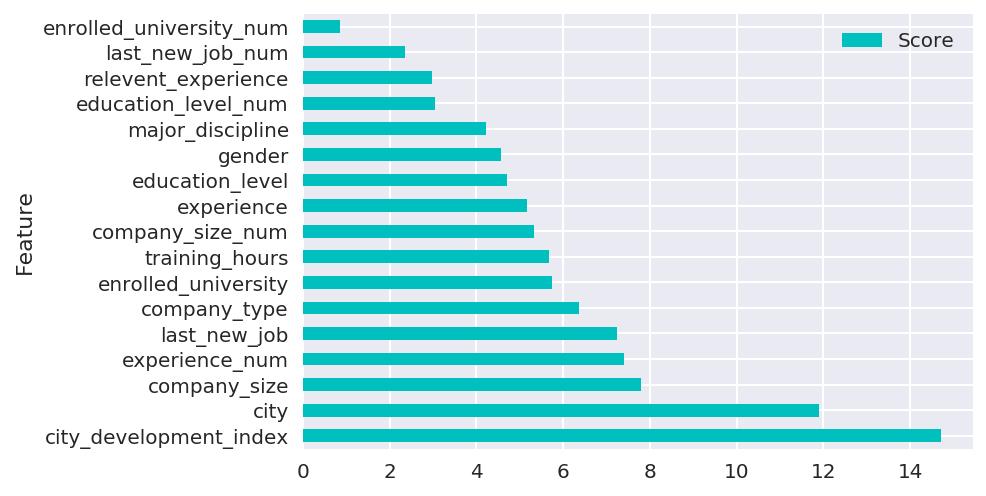

In [73]:
feature_score.plot('Feature', 'Score', kind='barh', color='c')

In [74]:
cat_cols

['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [75]:
labels.keys()

dict_keys(['enrolled_university', 'education_level', 'experience', 'company_size', 'last_new_job'])

In [77]:
trn = pd.read_csv(RAW/'train_jqd04QH.csv', low_memory=False)
tst = pd.read_csv(RAW/'test_GYi4Gz5.csv', low_memory=False)

In [80]:
trn.sample(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
9104,33370,city_114,0.926,Male,No relevent experience,Full time course,High School,NaN,6,NaN,NaN,1,264,0
4614,24897,city_89,0.925,Male,Has relevent experience,no_enrollment,Graduate,STEM,12,50-99,NaN,1,78,0
8945,1227,city_123,0.738,Male,No relevent experience,no_enrollment,Graduate,STEM,10,NaN,NaN,never,32,0
13734,13017,city_41,0.827,Male,Has relevent experience,no_enrollment,Graduate,STEM,17,100-500,Pvt Ltd,1,30,0
9436,26884,city_1,0.847,Male,Has relevent experience,no_enrollment,Graduate,STEM,15,10000+,NaN,3,35,0
6859,21003,city_73,0.754,Female,No relevent experience,no_enrollment,Graduate,STEM,6,10000+,Pvt Ltd,2,23,0
7886,31868,city_160,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,17,100-500,Pvt Ltd,1,6,0
5611,19260,city_16,0.910,Male,Has relevent experience,no_enrollment,Graduate,STEM,12,100-500,Pvt Ltd,4,2,0
13577,23953,city_19,0.682,Female,Has relevent experience,no_enrollment,Graduate,Other,>20,NaN,NaN,2,63,0
4494,19469,city_103,0.920,NaN,Has relevent experience,Full time course,Graduate,STEM,7,NaN,NaN,1,17,1


In [ ]:
# combine major_discipline with education level
# combine enrolled_university with major_discipline